In [1]:
# import os
import pandas as pd
import numpy as np

from helpers.dataset_process import dataset_to_df, search_df
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pywt import WaveletPacket2D as wp2d
import pywt
import cv2
from skimage.color import rgb2gray

In [2]:
path = '../../../data/CIFAK'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]

# for r_path in relative_paths:
#     remove_fname_space(path + r_path)

df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(
    path, relative_paths, paths_classes, 0.8, 0.19, 0.01)

In [3]:
path2 = '../../../data/meso_data'
relative_paths2= ["/Real", "/DeepFake"]
paths_classes2=['REAL',"FAKE"]


df_all2, df_train2, df_val2, df_test2, classes_stats2 = dataset_to_df(
    path2, relative_paths2, paths_classes2, 0.8, 0.19, 0.01)

In [4]:
search_df(df_all2,"82_678")

2937

In [5]:
def wp_decompose(image, wavelet_fun, level, format="Stack_ImgUseSameSize"):
    # This funtion decomposes the input 2D image into (2**level)**2 2D features
    # hence if we have only one level the output 2D features will be 4
    # The 2D features could be arranged as a matrix of (2**level) rows and (2**level) cols
    # ranging from the most approximate feature at location (0,0) to the most detailed
    # feature at location ((2**level) - 1,(2**level) - 1)
    # The original 2D wave_packet_decompose funtion down samples the input by 2 after each filter
    # Note: The 2D wave_packet_decompose funtion deals with a single channel image only.
    # hence you need to take a single channel out of the 3 channel coloured image
    # There is different options to take single channel, one of them is to convert to gray.
    #
    # This funtion gives the option to output the final features in one of 2 shapes:
    # 1) "stacked": in 3D matrix of a shape:(feature_height x feature_width x no_of_features)
    # 2) not "stacked": i.e. tiled in a 2D matrix of shape:
    # ((feature_height x features_rows) x (feature_width x features_cols))
    # note that features_rows = features_cols
    #
    # The format switch can take one of three values:
    # "Tile": apply wavelet --> features with smaller size --> tile the features to form a matrix similar size to the image
    # "Stack_ImgUseSameSize": Up-size image --> apply wavelet --> features size = image size
    # "Stack_ImgUseFeatureSize": apply wavelet --> features with smaller size --> downsize original image to feature size
    # Finally concatenate features to original image

    img_h = image.shape[0]
    features_rows = 2**level

    if format == "Stack_ImgUseSameSize":
        if level == 1:
            new_size = (img_h-1)*features_rows
        else:
            new_size = (img_h-2)*features_rows
        assert new_size < 2048

        dim = (new_size, new_size)
        # Apply wavelet packet on a resized version of the image
        resized_img = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)

    elif format == "Tile":
        if level == 1:
            new_size = (img_h-2)
        else:
            new_size = (img_h-2*features_rows)

        dim = (new_size, new_size)
        # Apply wavelet packet on a resized version of the image
        resized_img = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)
    else:
        resized_img = image

    img_one_channel = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

    # apply wavelet packet transform
    wp = wp2d(data=img_one_channel, wavelet=wavelet_fun, mode='symmetric')

    # get the paths of the image
    paths = [node.path for node in wp.get_level(level)]

    # Arrange the paths in a 2D matrix shape, useful to visualize the wavelet packet features
    # also needed to output to arrange the features in a tile format.
    paths_rows = []
    paths_matrix = []
    for i, path in enumerate(paths):
        if (i+1) % features_rows == 0:
            paths_rows.append(path)
            paths_matrix.append(paths_rows)
            paths_rows = []
        else:
            paths_rows.append(path)

    if format == "Tile":
        nodes_matrix = []
        for row in paths_matrix:
            nodes_rows = []
            # print(row)  # >>>>>>
            for element in row:
                nodes_rows.append(wp[element].data)
            nodes_matrix.append(nodes_rows)

        nodes_tiled = np.array(nodes_matrix)
        # print("nodes_tiled", nodes_tiled.shape)  # >>>>>>
        # print("total shape", nodes_tiled.shape[-1]*features_rows)  # >>>>>>
        nodes_arr = nodes_tiled.swapaxes(2, 1).reshape(img_h, img_h, 1)
        # print("nodes_arr", nodes_arr.shape)  # >>>>>>
        # print("nodes_arr", nodes_arr)  # >>>>>>
        axis = 2
    else:
        nodes = [wp[path].data for path in paths]
        nodes_arr = np.transpose(np.array(nodes), (1, 2, 0))
        axis = 2

    if format == "Stack_ImgUseFeatureSize":
        output_dim = wp[paths[0]].data.shape
        # print("output_dim", output_dim)  # >>>>>>
        output_image = cv2.resize(
            image, output_dim, interpolation=cv2.INTER_LINEAR)
    else:
        output_image = image

    # print("axis", axis) # >>>>>>

    img_and_nodes_array = np.concatenate((output_image, nodes_arr), axis=axis)

    ###############################################################################
    wp_fun = wp[paths[0]].wavelet.wavefun()
    # x, y = wp_fun[-1], wp_fun[0]
    wp_name = wp[paths[0]].wavelet.family_name

    return img_and_nodes_array, paths, resized_img, features_rows, wp_fun, wp_name

In [6]:
def plot_wp_nodes(image, wavelet_fun, level, format):
    nodes, paths, _, rows, *_ = wp_decompose(image, wavelet_fun, level, format)

    plt.rcParams['figure.constrained_layout.use'] = True
    # plt.rcParams["figure.autolayout"] = True

    fig = plt.figure(figsize=(12, 12))
    subfigs = fig.subfigures(2, 1, height_ratios=[
                             1, 1.5], hspace=0.1, squeeze='True')

    # axs0 = subfigs[0].subplots(1, 1)
    # axs0.imshow(image)
    # # axs0.set_xticks([])
    # # axs0.set_yticks([])
    # axs0.set_title("Sample Input Image")

    axs1 = subfigs[0].subplots(1, 1)
    axs1.imshow(nodes[:, :, :3].astype(np.uint8))
    # axs0.set_xticks([])
    # axs0.set_yticks([])
    axs1.set_title("Adjusted Image")

    if format != "Tile":
        grid = ImageGrid(subfigs[1], 111, nrows_ncols=(
            rows, rows), axes_pad=0.3)

        for i, ax in enumerate(grid):

            ax.imshow(nodes[:, :, i+3])
            # ax.set_xticks([])
            # ax.set_yticks([])
            ax.set_title(paths[i])
        features_text = "Features extracted using Wavelet Packet Transform"
        subfigs[1].suptitle(features_text)
    else:

        axs2 = subfigs[1].subplots(1, 1)
        axs2.imshow(nodes[:, :, 3])
        # axs0.set_xticks([])
        # axs0.set_yticks([])
        axs2.set_title("Tiled Features")

In [7]:
def plot_wp_fun(image, wavelet_fun, level, format):
    *_, wp_fun, wp_name = wp_decompose(image, wavelet_fun, level, format)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')

    axs[0].plot(wp_fun[-1], wp_fun[0])
    axs[0].grid(True)
    axs[0].set_title(f'{wavelet_fun}')

    w = pywt.Wavelet(wavelet_fun)
    (phi, psi, x) = w.wavefun(level=level)

    axs[1].plot(x, phi)
    axs[1].grid(True)
    axs[1].set_title(f'{wavelet_fun} phi')

    axs[2].plot(x, psi)
    axs[2].grid(True)
    axs[2].set_title(f'{wavelet_fun} psi')

In [35]:
image = plt.imread(df_all.iloc[2937, 0])
# image = plt.imread(df_all2.iloc[2937, 0])
print("input image shape", image.shape)

input image shape (32, 32, 3)


In [45]:
w_family = pywt.families()
wavelet_lst = []
for i, w_fun in enumerate(w_family):
    wavelet_lst.append(pywt.wavelist(w_fun))
    formatted_w_fun = f'{i}) {w_fun}: {", ".join(pywt.wavelist(w_fun))}'
    print(formatted_w_fun)
print(" \n")


i = 1  # index of the main wavelet category
j = 1  # index of the sub wavelet funtion
wavelet_fun = wavelet_lst[i][j]
# wavelet_fun = 'db2'
print("Used Wavelet funtion:", wavelet_fun, "\n")

level = 2

format = "Stack_ImgUseSameSize"
# format = "Stack_ImgUseFeatureSize"
# format = "Tile"

0) haar: haar
1) db: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
2) sym: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
3) coif: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
4) bior: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
5) rbio: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
6) dmey: dmey
7) gaus: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
8) mexh: mexh
9) morl: morl
10) cgau: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, cgau8
11) shan: shan
12) fbsp: fbsp
13) cmo

nodes shape (32, 32, 19)


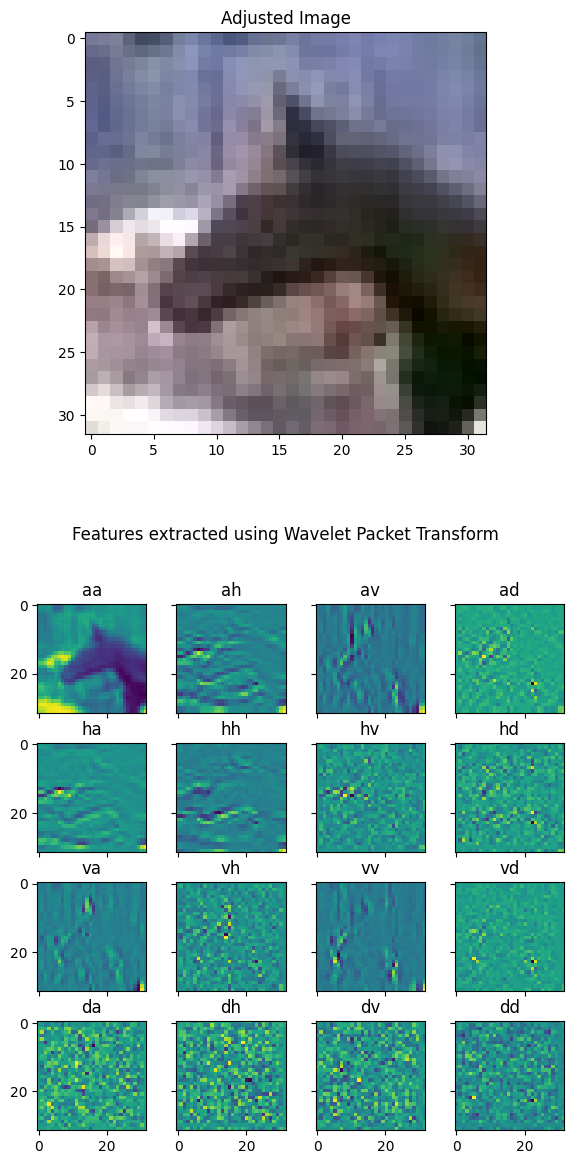

In [46]:
nodes,_, resized_img, *_ = wp_decompose(image, wavelet_fun, level, format)

print("nodes shape", nodes.shape)
# fig, axs = plt.subplots(1, 3, layout="constrained", figsize=(12, 4))
# axs[0].imshow(nodes[:, :, :3].astype(np.uint8))
# axs[1].imshow(resized_img)
# axs[2].imshow(nodes[:, :, -1])

plot_wp_nodes(image, wavelet_fun, level, format)

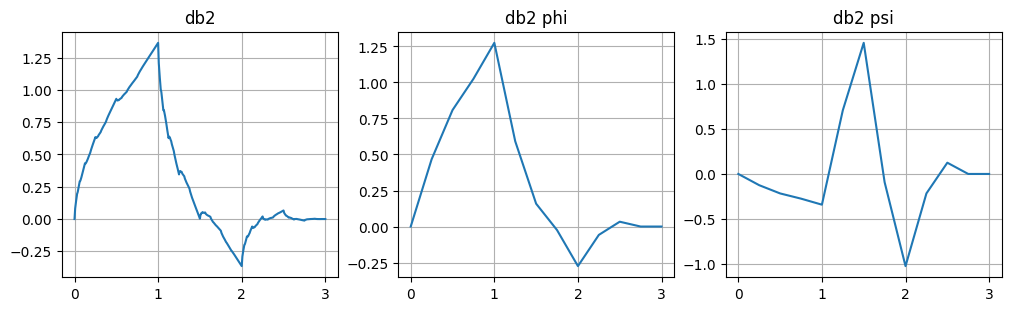

In [47]:
plot_wp_fun(image, wavelet_fun, level, format)